In [258]:
import os
from IPython.display import display, clear_output
from xgboost import XGBRegressor
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, ParameterGrid, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.decomposition import PCA

from statsmodels.tsa.stattools import adfuller, kpss, coint
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import random
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
plt.style.use('ggplot')
pd.options.display.float_format = '{:.4f}'.format

os.chdir('/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA')
os.getcwd()

'/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA'

In [265]:
# Дата, которая разделяет тренировочную и тестовую выборки, чтобы делить выборки для всех моделей
train_test_split_date = '2022-06-01'

# импортируем данные и делим их по дате
df = pd.read_csv('final_regional_df/infl_Свердловская_область.csv')
df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='ME')
df.drop(['unemp', 'paid_services'], axis=1, inplace=True)

df_train = df[df['date'] < train_test_split_date].copy()
df_test = df[df['date'] >= train_test_split_date].copy()

# Делим Датафреймы на эндогенные и экзогенные переменные
y_train = df_train['inflation']
y_test = df_test['inflation']
df_train.drop(['inflation', 'date'], axis=1, inplace=True)
df_test.drop(['inflation', 'date'], axis=1, inplace=True)
X_train = df_train.copy()
X_test = df_test.copy()

dummies_train = pd.DataFrame(0, index=y_train.index, columns=['outlier_12', 'outlier_98'])
dummies_test = pd.DataFrame(0, index=y_test.index, columns=['outlier_12', 'outlier_98'])
dummies_train.iloc[12, 0] = 1  # Дамми для индекса 12
dummies_train.iloc[98, 1] = 1  # Дамми для индекса 98

# Добавляем дамми-переменные к экзогенным факторам
X_train = pd.concat([X_train, dummies_train], axis=1)
X_test = pd.concat([X_test, dummies_test], axis=1)

In [278]:
ardl_df = pd.DataFrame()

res = ARDL(
        y_train,
        2,
        X_train,
        2,
        trend='n'
).fit()
ardl_df = pd.concat([res.params, res.pvalues],axis=1)
ardl_df.columns = ['coef', 'p-value']
ardl_df.drop(['p-value', 'coef'], axis=1, inplace=True)

## ARDL


In [276]:
# Дата, которая разделяет тренировочную и тестовую выборки, чтобы делить выборки для всех моделей
train_test_split_date = '2022-06-01'
file_names = os.listdir('/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA/final_regional_df')
source_path = os.path.join(os.getcwd(), 'final_regional_df')

def add_stars(row):
    coef = row['coef']
    pval = row['p-value']
    if pval < 0.01:
        return f"{coef:.2f}***"
    elif pval < 0.05:
        return f"{coef:.2f}**"
    elif pval < 0.1:
        return f"{coef:.2f}*"
    else:
        return f"{coef:.2f}"
    
def get_max_lags_dict(df_result, p_value_threshold=0.05):
    df = df_result.copy()
    # Получаем уникальные регрессоры (исключая 'inflation')
    regressors = [col for col in df['regr'].unique() if col != 'inflation']
    # Создаем словарь с максимальными лагами только для значимых коэффициентов (p-value <= 0.05)
    max_lags_dict = {}
    for regr in regressors:
        # Находим значимые строки для текущего регрессора (p-value <= 0.05)
        regr_data = df[(df['regr'] == regr) & (df['p-value'] <= 0.05)]
        if not regr_data.empty:
            # Берем максимальный значимый лаг
            max_lag = regr_data['lag'].max()
        else:
            # Если нет значимых коэффициентов, ставим 0
            max_lag = 0
        max_lags_dict[regr] = max_lag

    # Добавляем регрессоры, которых нет в данных, но которые нужны в словаре
    required_regressors = X_train.columns
    for regr in required_regressors:
        if regr not in max_lags_dict:
            max_lags_dict[regr] = 0

    max_lags_dict = {k: max_lags_dict[k] for k in max_lags_dict}
    max_lags_dict = {k: int(v) if isinstance(v, str) else v for k, v in sorted(max_lags_dict.items())}
    
    return max_lags_dict

for file_name in tqdm(file_names):                    
    df = pd.read_csv(f'{os.path.join(source_path, file_name)}').reset_index(drop=True).dropna()
    df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='ME')
    df.drop(['unemp', 'paid_services'], axis=1, inplace=True)

    df_train = df[df['date'] < train_test_split_date].copy()
    df_test = df[df['date'] >= train_test_split_date].copy()

    # Делим Датафреймы на эндогенные и экзогенные переменные
    y_train = df_train['inflation'].copy() * 100
    y_test = df_test['inflation'].copy() * 100
    df_train.drop(['inflation', 'date'], axis=1, inplace=True)
    df_test.drop(['inflation', 'date'], axis=1, inplace=True)
    X_train = df_train.copy()
    X_test = df_test.copy()

    dummies_train = pd.DataFrame(0, index=y_train.index, columns=['outlier_12', 'outlier_98'])
    dummies_test = pd.DataFrame(0, index=y_test.index, columns=['outlier_12', 'outlier_98'])
    dummies_train.iloc[12, 0] = 1  # Дамми для индекса 12
    dummies_train.iloc[98, 1] = 1  # Дамми для индекса 98

    # Добавляем дамми-переменные к экзогенным факторам
    X_train = pd.concat([X_train, dummies_train], axis=1)
    X_test = pd.concat([X_test, dummies_test], axis=1)

    res = ARDL(y_train, 2, X_train, order=2, trend='n').fit()
    df_result_region = pd.concat([res.params, res.pvalues], axis=1).reset_index()
    df_result_region.columns = ['regr', 'coef', 'p-value']
    df_result_region['lag'] = df_result_region['regr'].apply(lambda x: re.findall(r'[0-9]', x)[-1])
    df_result_region['regr'] = df_result_region['regr'].apply(lambda x: re.sub(r'.L\d+', '', x))
    df_result_region = df_result_region.loc[df_result_region['p-value'] < 0.3]
    
    res = ARDL(
        y_train,
        2,
        X_train,
        get_max_lags_dict(df_result_region),
        trend='n'
    ).fit()
    result = pd.concat([res.params, res.pvalues],axis=1)
    result.columns = ['coef', 'p-value']
    result[f'{file_name[5:-4]}'] = result.apply(add_stars, axis=1)
    result.drop(['p-value', 'coef'], axis=1, inplace=True)
    ardl_df_left = ardl_df.copy()
    ardl_df_left = pd.merge(ardl_df_left, result, left_index=True, right_index=True, how='left')
    ardl_df_inner = ardl_df.copy()
    ardl_df_inner = pd.merge(ardl_df_inner, result, left_index=True, right_index=True, how='inner')
    
ardl_df_left

100%|██████████| 78/78 [00:01<00:00, 54.94it/s]


,Алтайский_край,Волгоградская_область,Амурская_область,Еврейская_автономная_область,г._Санкт-Петербург,Приморский_край,Республика_Ингушетия,Астраханская_область,Тамбовская_область,Республика_Мордовия,...,Тюменская_область,Ульяновская_область,Вологодская_область,Челябинская_область,Самарская_область,Смоленская_область,Республика_Калмыкия,Пермский_край,Калужская_область_x,Калужская_область_y
inflation.L1,0.18,0.58***,0.82***,0.88***,1.21***,0.71***,0.72***,0.99***,0.85***,0.93***,...,0.92***,0.33**,0.47***,0.50***,0.44***,0.76***,0.71***,0.61***,0.29**,0.29**
inflation.L2,0.20***,0.42***,0.18,0.12**,-0.22**,0.29**,0.28***,0.01,0.15**,0.07,...,0.07,0.08,0.52***,0.50***,0.15*,-0.50***,0.29***,0.05,0.09,0.09
Brent.L0,0.01,-0.01,-0.00,0.01**,0.03**,0.00,-0.01,0.00,0.01,0.01,...,0.01,0.01,0.01*,-0.00,0.02**,0.02*,0.00,0.00,0.02**,0.02**
Brent.L1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN
Brent.L2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.01*,NaN,NaN,NaN,NaN,NaN
MIACR.L0,0.58***,0.53***,0.49***,0.60***,0.15***,0.49***,0.37***,0.50***,0.58***,0.50***,...,0.60***,0.68***,0.65***,0.58***,0.58***,0.16***,0.64***,0.72***,0.63***,0.63***
MIACR.L1,-0.50***,-0.67***,-0.50***,-0.59***,NaN,-0.48***,NaN,-0.44***,-0.55***,-0.49***,...,-0.57***,-0.64***,-0.59***,-0.57***,-0.54***,NaN,-0.63***,-0.73***,-0.57***,-0.57***
MIACR.L2,NaN,0.17**,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
obligates.L0,-0.06,-0.12*,-0.19***,-0.03,0.34***,-0.26***,0.10,-0.10,-0.13**,-0.02,...,-0.03,-0.04,0.03,-0.15**,-0.06,0.05,-0.01,-0.27***,-0.07,-0.07
obligates.L1,NaN,NaN,NaN,-0.23***,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.09,NaN,NaN,NaN,NaN,NaN,NaN


In [277]:
ardl_df_inner

,Алтайский_край,Волгоградская_область,Амурская_область,Еврейская_автономная_область,г._Санкт-Петербург,Приморский_край,Республика_Ингушетия,Астраханская_область,Тамбовская_область,Республика_Мордовия,...,Тюменская_область,Ульяновская_область,Вологодская_область,Челябинская_область,Самарская_область,Смоленская_область,Республика_Калмыкия,Пермский_край,Калужская_область_x,Калужская_область_y
inflation.L1,0.18,0.58***,0.82***,0.88***,1.21***,0.71***,0.72***,0.99***,0.85***,0.93***,...,0.92***,0.33**,0.47***,0.50***,0.44***,0.76***,0.71***,0.61***,0.29**,0.29**
inflation.L2,0.20***,0.42***,0.18,0.12**,-0.22**,0.29**,0.28***,0.01,0.15**,0.07,...,0.07,0.08,0.52***,0.50***,0.15*,-0.50***,0.29***,0.05,0.09,0.09
Brent.L0,0.01,-0.01,-0.00,0.01**,0.03**,0.00,-0.01,0.00,0.01,0.01,...,0.01,0.01,0.01*,-0.00,0.02**,0.02*,0.00,0.00,0.02**,0.02**
MIACR.L0,0.58***,0.53***,0.49***,0.60***,0.15***,0.49***,0.37***,0.50***,0.58***,0.50***,...,0.60***,0.68***,0.65***,0.58***,0.58***,0.16***,0.64***,0.72***,0.63***,0.63***
MIACR.L1,-0.50***,-0.67***,-0.50***,-0.59***,NaN,-0.48***,NaN,-0.44***,-0.55***,-0.49***,...,-0.57***,-0.64***,-0.59***,-0.57***,-0.54***,NaN,-0.63***,-0.73***,-0.57***,-0.57***
obligates.L0,-0.06,-0.12*,-0.19***,-0.03,0.34***,-0.26***,0.10,-0.10,-0.13**,-0.02,...,-0.03,-0.04,0.03,-0.15**,-0.06,0.05,-0.01,-0.27***,-0.07,-0.07
M2.L0,4.41,-13.80*,7.59,14.85**,-1.64,-2.58,-2.41,6.35,0.87,14.49**,...,2.80,8.64*,3.24,0.59,6.99,-6.65,18.28**,21.97***,16.37***,16.37***
money_income.L0,0.85,9.83***,-0.58,1.51,0.08,1.55,-1.17,-0.30,0.61,-3.45*,...,0.02,-0.84,-4.43***,3.87*,0.73,6.91*,-0.10,2.24,-2.80,-2.80
trade_turnover.L0,4.19***,1.26,0.46,0.76,1.77,1.93**,0.64,1.37,-0.85,1.02,...,0.42,3.65***,-0.95,-3.39**,2.32***,5.67***,2.49,1.98***,3.81***,3.81***
debt_firms.L0,0.62,2.31,-1.34,0.64,8.41**,0.13,0.37,4.67,0.40,4.02**,...,4.60**,-1.91*,0.04,1.22,0.20,-1.77***,1.32,-1.79,-2.70,-2.70


❌ Error in infl_Калужская_область.csv: Prediction must have `end` after `start`.


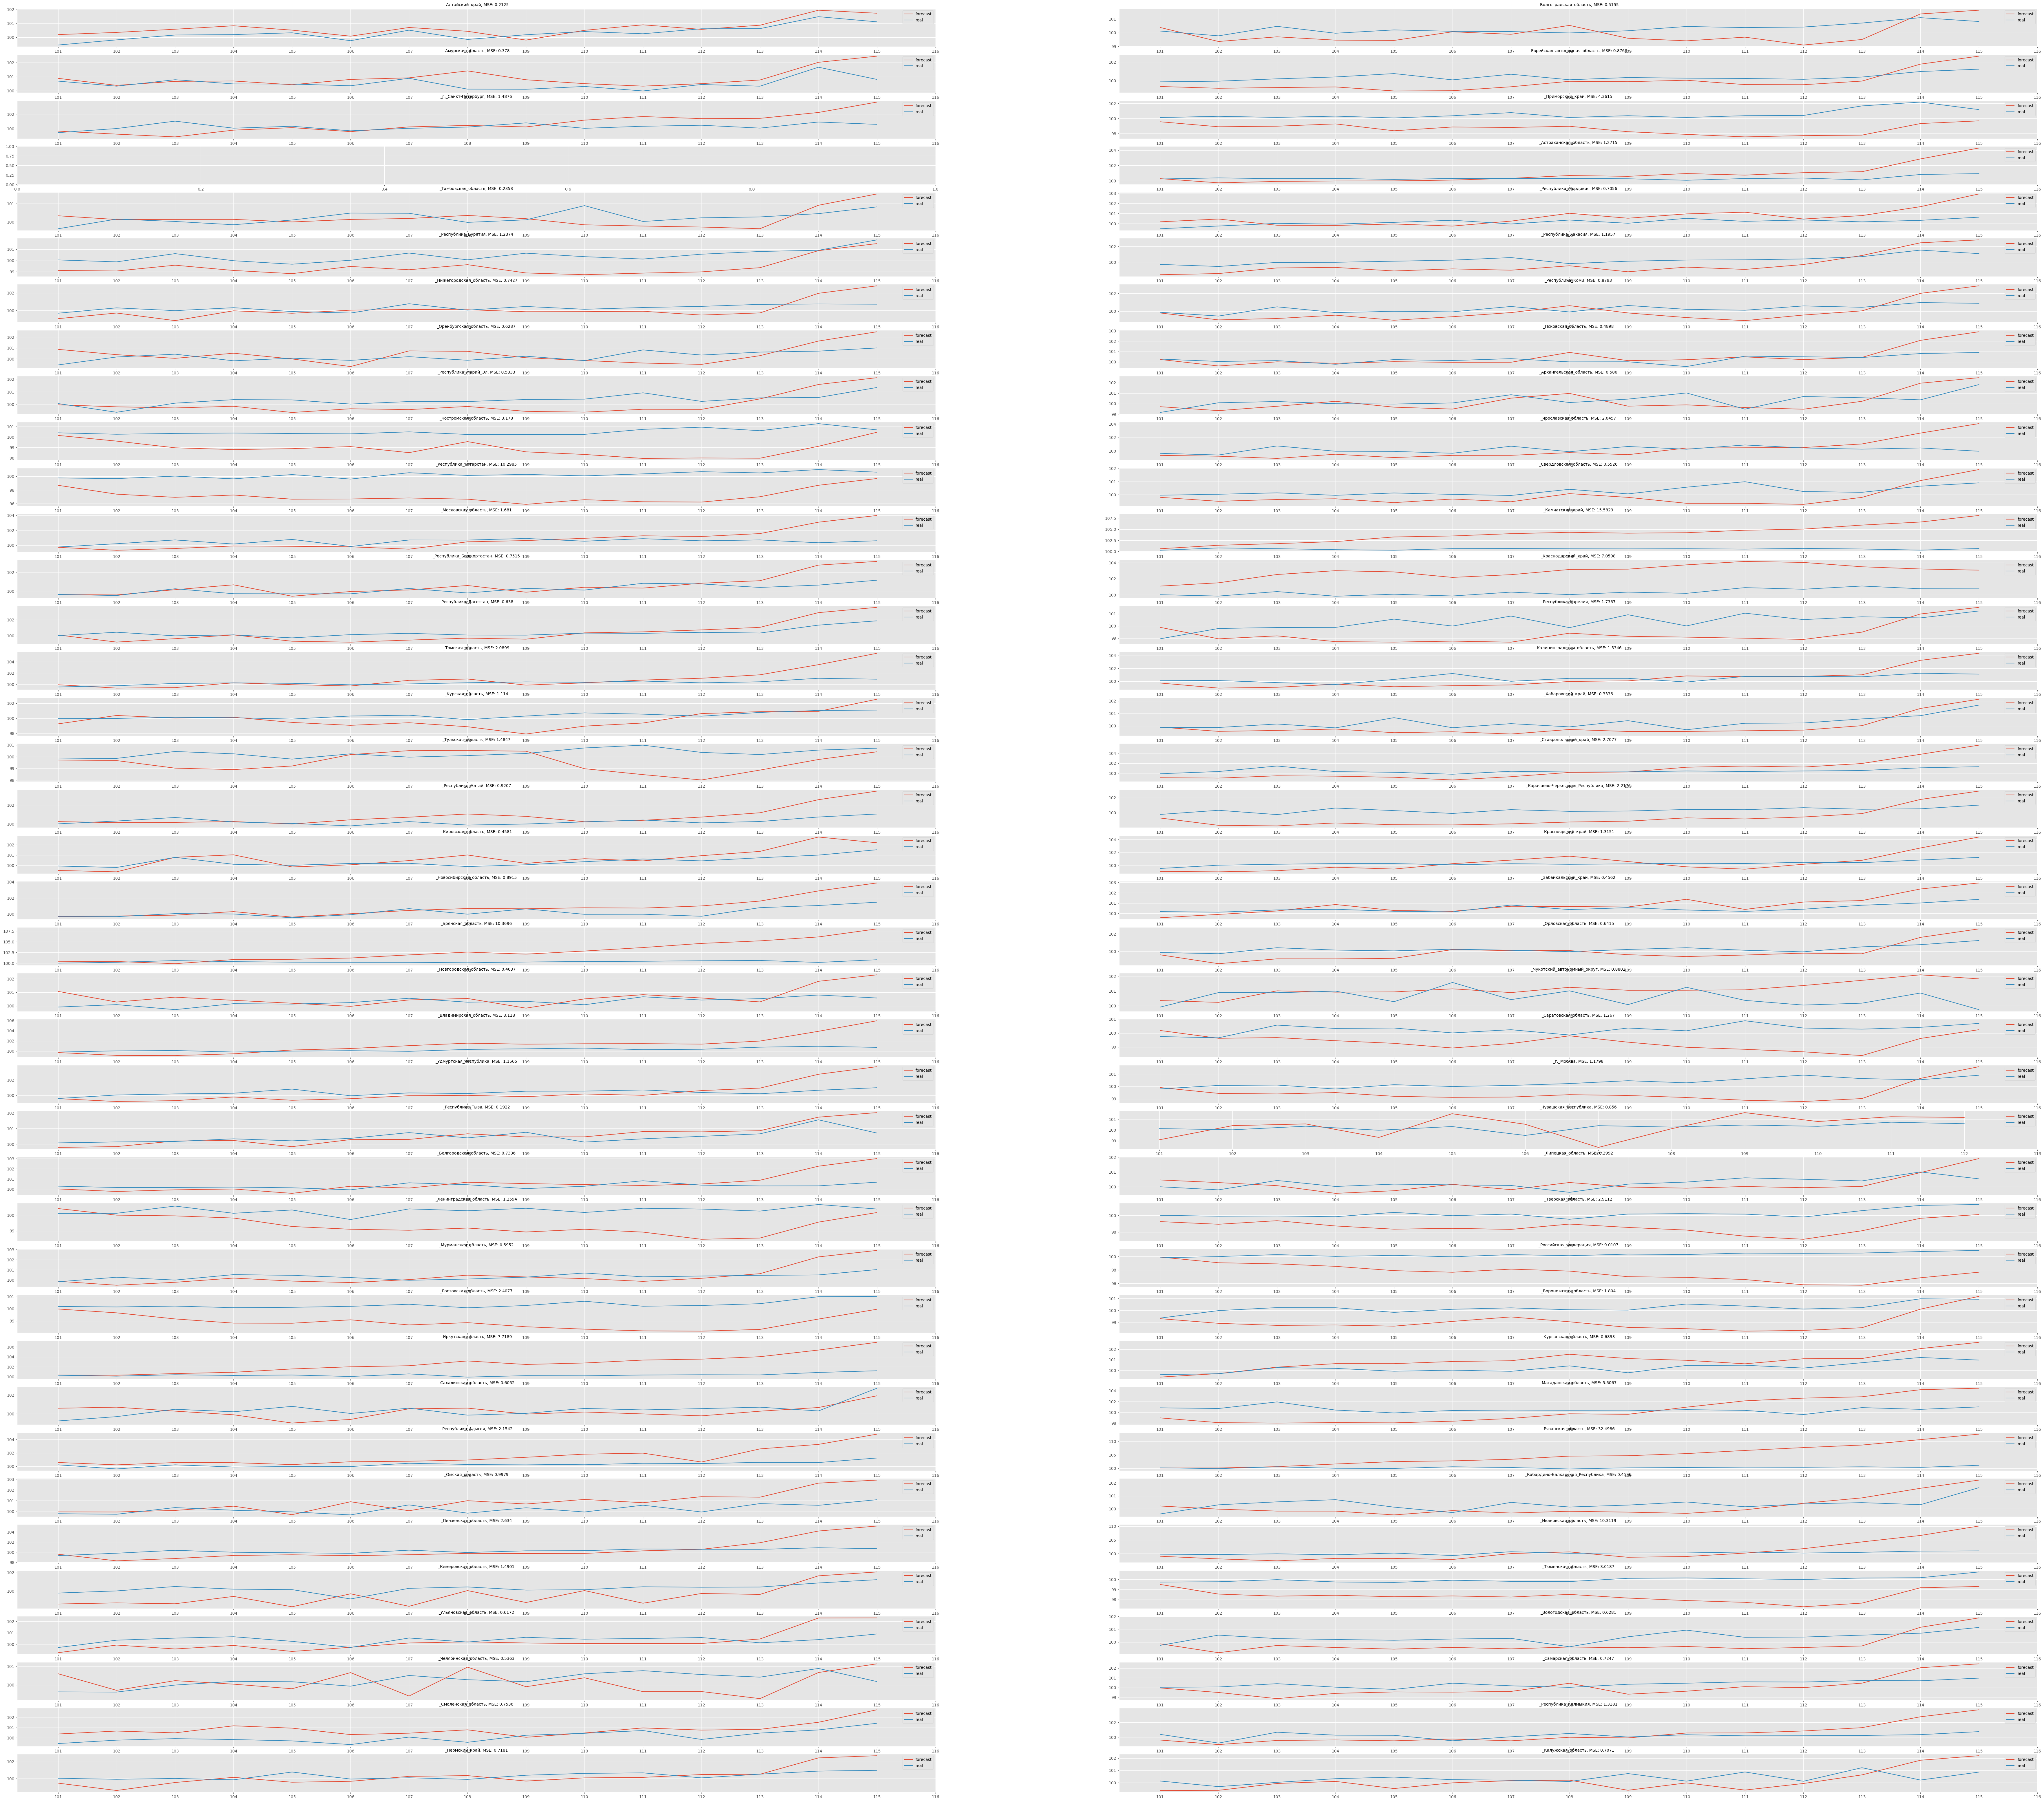

In [169]:
rows = 39
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(90, 80), dpi=100)

for i in range(len(file_names)):
    try: 
        row = i // cols
        col = i % cols
        df = pd.read_csv(f'{os.path.join(source_path, file_names[i])}').reset_index(drop=True).dropna()
        df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='ME')
        df.drop(['unemp', 'paid_services'], axis=1, inplace=True)

        df_train = df[df['date'] < train_test_split_date].copy()
        df_test = df[df['date'] >= train_test_split_date].copy()

        # Делим Датафреймы на эндогенные и экзогенные переменные
        y_train = df_train['inflation'].copy() * 100
        y_test = df_test['inflation'].copy() * 100
        df_train.drop(['inflation', 'date'], axis=1, inplace=True)
        df_test.drop(['inflation', 'date'], axis=1, inplace=True)
        X_train = df_train.copy()
        X_test = df_test.copy()

        dummies_train = pd.DataFrame(0, index=y_train.index, columns=['outlier_12', 'outlier_98'])
        dummies_test = pd.DataFrame(0, index=y_test.index, columns=['outlier_12', 'outlier_98'])
        dummies_train.iloc[12, 0] = 1  # Дамми для индекса 12
        dummies_train.iloc[98, 1] = 1  # Дамми для индекса 98

        # Добавляем дамми-переменные к экзогенным факторам
        X_train = pd.concat([X_train, dummies_train], axis=1)
        X_test = pd.concat([X_test, dummies_test], axis=1)

        res = ARDL(y_train, 2, X_train, order=2, trend='n').fit()
        df_result_region = pd.concat([res.params, res.pvalues], axis=1).reset_index()
        df_result_region.columns = ['regr', 'coef', 'p-value']
        df_result_region['lag'] = df_result_region['regr'].apply(lambda x: re.findall(r'[0-9]', x)[-1])
        df_result_region['regr'] = df_result_region['regr'].apply(lambda x: re.sub(r'.L\d+', '', x))
        df_result_region = df_result_region.loc[df_result_region['p-value'] < 0.3]
        
        res = ARDL(
            y_train,
            2,
            X_train,
            get_max_lags_dict(df_result_region),
            trend='n'
        ).fit()
        forecast = res.forecast(steps=len(y_test), exog=X_test[:len(y_test)])
        mse = mean_squared_error(y_test, forecast)
        axes[row, col].plot(y_test.index, forecast, label='forecast');
        axes[row, col].plot(y_test.index, y_test, label='real');        
        axes[row, col].set_xticks(np.arange(len(y_train), len(y_train)+len(y_test)+1, 1))
        axes[row, col].set_title(f'{file_names[i][4:-4]}, MSE: {round(mse,4)}', fontsize=10)
        axes[row, col].legend()
    except Exception as e:
        print(f"❌ Error in {file_name}: {str(e)}")
        continue
plt.savefig('result/ARDL_predict.pdf')

## XGBoost


### Без сглаживания шоков без PCA


Mean Squared Error: 0.0314
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


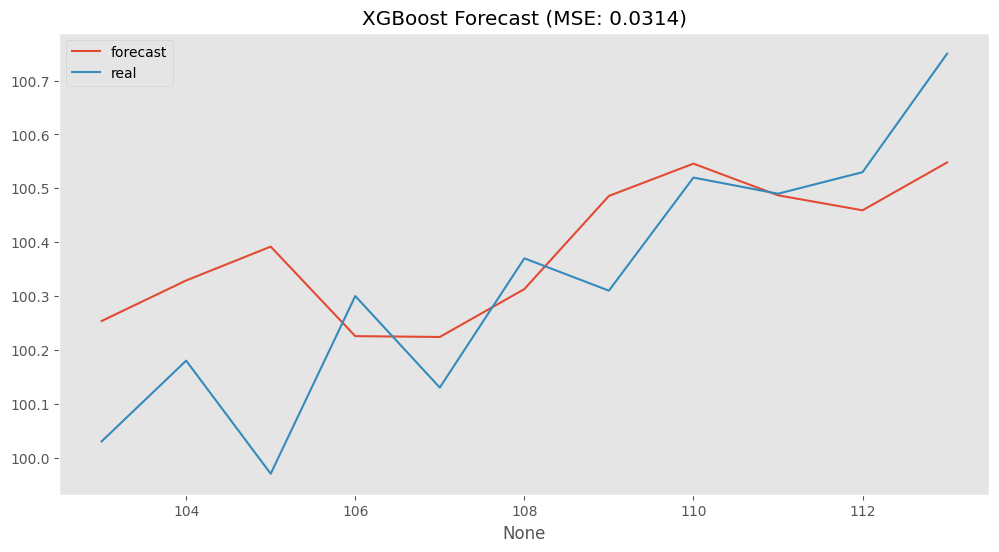

In [16]:
df_1 = df.drop(['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4',	'PCA_5',
               'PCA_6', 'PCA_7', 'PCA_8'], axis=1, inplace=False)
df_train = df_1[df_1['date'] < train_test_split_date].copy()
df_test = df_1[df_1['date'] >= train_test_split_date].copy()
y_train = df_train['inflation']
y_test = df_test['inflation']
df_train.drop(['inflation', 'date'], axis=1, inplace=True)
df_test.drop(['inflation', 'date'], axis=1, inplace=True)
X_train = df_train.copy()
X_test = df_test.copy()


def create_features(df, target_col='inflation', n_lags=3, window_size=3):
    # 1. Авторегрессионные компоненты (лаги)
    for lag in range(1, n_lags+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    # 2. Скользящие статистики
    df['rolling_mean'] = df[target_col].rolling(
        window=window_size).mean().shift(1)
    df['rolling_std'] = df[target_col].rolling(
        window=window_size).std().shift(1)
    # 3. Временные фичи из даты
    df['month'] = df['ds'].dt.month
    df['quarter'] = df['ds'].dt.quarter
    df['year'] = df['ds'].dt.year
    df['days_in_month'] = df['ds'].dt.days_in_month
    # 4. Дополнительные преобразования
    df['time_idx'] = (df['ds'] - df['ds'].min()).dt.days

    return df.dropna()


# Загрузка данных
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

y_train['ds'] = pd.date_range(
    start='2014-01-01', freq='ME', periods=len(y_train))
y_test['ds'] = pd.date_range(end='2023-08-31', freq='ME', periods=len(y_test))

# Создаем фичи для train и test
train_feats = create_features(y_train)
test_feats = create_features(y_test)

# Разделяем на X и y
X_train_infl = train_feats.drop(
    columns=['inflation', 'ds'], axis=1).join(X_train)
y_train = train_feats['inflation']

X_test_infl = test_feats.drop(columns=['inflation', 'ds'], axis=1).join(X_test)
y_test = test_feats['inflation']

# Настройка кросс-валидации для временных рядов
tscv = TimeSeriesSplit(n_splits=3)
# Параметры для подбора
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Инициализация и обучение модели
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_infl, y_train)

# Предсказание
xgb_pred = grid_search.predict(X_test_infl)
# Оценка качества
mse = mean_squared_error(y_test, xgb_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Best params: {grid_search.best_params_}")

# Визуализация
plt.figure(figsize=(12, 6))
sb.lineplot(x=y_test.index, y=xgb_pred, label='forecast')
y_test.plot(label='real')
plt.title(f"XGBoost Forecast (MSE: {mse:.4f})")
plt.legend()
plt.grid()
plt.show()

### Без сглаживания шоков с PCA


Mean Squared Error: 0.0363
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


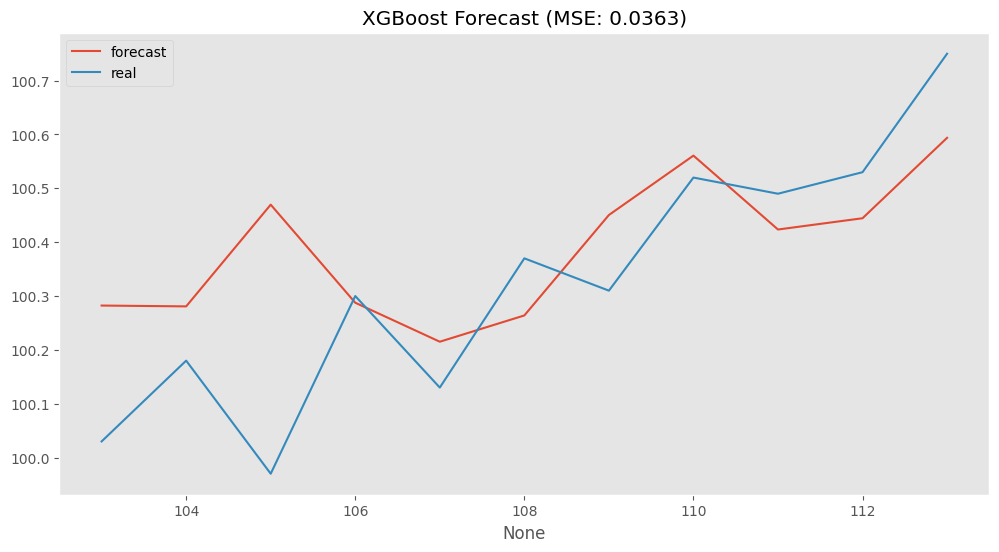

In [17]:
# Дата, которая разделяет тренировочную и тестовую выборки, чтобы делить выборки для всех моделей
train_test_split_date = '2022-05-01'

# импортируем данные и делим их по дате
df = pd.read_csv('final_regional_df/infl_Российская_Федерация.csv')
df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='ME')
df.drop(['unemp', 'paid_services'], axis=1, inplace=True)

df_train = df[df['date'] < train_test_split_date].copy()
df_test = df[df['date'] >= train_test_split_date].copy()

# Делим Датафреймы на эндогенные и экзогенные переменные
y_train = df_train['inflation']
y_test = df_test['inflation']
df_train.drop(['inflation', 'date'], axis=1, inplace=True)
df_test.drop(['inflation', 'date'], axis=1, inplace=True)
X_train = df_train.copy()
X_test = df_test.copy()

dummies_train = pd.DataFrame(0, index=y_train.index, columns=[
                             'outlier_12', 'outlier_98'])
dummies_test = pd.DataFrame(0, index=y_test.index, columns=[
                            'outlier_12', 'outlier_98'])
dummies_train.iloc[12, 0] = 1  # Дамми для индекса 12
dummies_train.iloc[98, 1] = 1  # Дамми для индекса 98

# Добавляем дамми-переменные к экзогенным факторам
X_train = pd.concat([X_train, dummies_train], axis=1)
X_test = pd.concat([X_test, dummies_test], axis=1)

# Загрузка данных
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

y_train['ds'] = pd.date_range(
    start='2014-01-01', freq='ME', periods=len(y_train))
y_test['ds'] = pd.date_range(end='2023-08-31', freq='ME', periods=len(y_test))

# Создаем фичи для train и test
train_feats = create_features(y_train)
test_feats = create_features(y_test)


# Разделяем на X и y
X_train_infl = train_feats.drop(columns=['inflation', 'ds']).join(X_train)
y_train = train_feats['inflation']

X_test_infl = test_feats.drop(columns=['inflation', 'ds']).join(X_test)
y_test = test_feats['inflation']

# Настройка кросс-валидации для временных рядов
tscv = TimeSeriesSplit(n_splits=3)
# Параметры для подбора
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Инициализация и обучение модели
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_infl, y_train)

# Предсказание
xgb_pred = grid_search.predict(X_test_infl)
# Оценка качества
mse = mean_squared_error(y_test, xgb_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Best params: {grid_search.best_params_}")

# Визуализация
plt.figure(figsize=(12, 6))
sb.lineplot(x=y_test.index, y=xgb_pred, label='forecast')
y_test.plot(label='real')
plt.title(f"XGBoost Forecast (MSE: {mse:.4f})")
plt.legend()
plt.grid()
plt.show()

### С сглаживанием шоков без PCA


Mean Squared Error: 0.0264
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


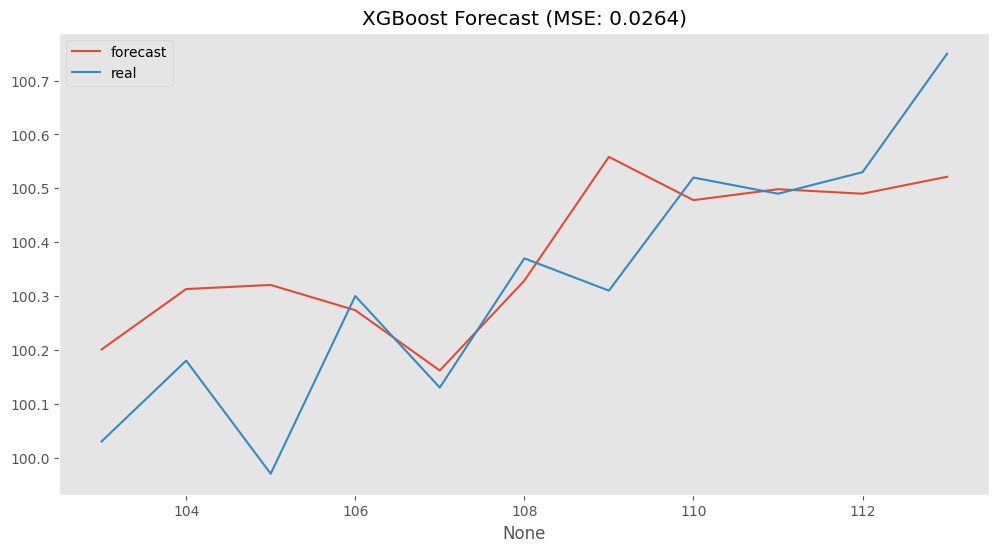

In [18]:
df_1 = df.drop(['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4',	'PCA_5',
               'PCA_6', 'PCA_7', 'PCA_8'], axis=1, inplace=False)
df_train = df_1[df_1['date'] < train_test_split_date].copy()
df_test = df_1[df_1['date'] >= train_test_split_date].copy()
y_train = df_train['inflation']
y_test = df_test['inflation']
df_train.drop(['inflation', 'date'], axis=1, inplace=True)
df_test.drop(['inflation', 'date'], axis=1, inplace=True)
X_train = df_train.copy()
X_test = df_test.copy()

# СДЕЛАЛ УСРЕДНЕНИЕ ШОКОВ
y_train[12] = (y_train[11] + y_train[13]) / 2
y_train[98] = (y_train[97] + y_train[99]) / 2
# Загрузка данных
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

y_train['ds'] = pd.date_range(
    start='2014-01-01', freq='ME', periods=len(y_train))
y_test['ds'] = pd.date_range(end='2023-08-31', freq='ME', periods=len(y_test))
# Создаем фичи для train и test
train_feats = create_features(y_train)
test_feats = create_features(y_test)
# Разделяем на X и y
y_train = train_feats['inflation']
X_train_infl = train_feats.drop(columns=['inflation', 'ds']).join(X_train)

y_test = test_feats['inflation']
X_test_infl = test_feats.drop(columns=['inflation', 'ds']).join(X_test)
# Настройка кросс-валидации для временных рядов
tscv = TimeSeriesSplit(n_splits=3)
# Параметры для подбора
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
# Инициализация и обучение модели
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_infl, y_train)
# Предсказание
xgb_pred = grid_search.predict(X_test_infl)
# Оценка качества
mse = mean_squared_error(y_test, xgb_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Best params: {grid_search.best_params_}")

# Визуализация
plt.figure(figsize=(12, 6))
sb.lineplot(x=y_test.index, y=xgb_pred, label='forecast')
y_test.plot(label='real')
plt.title(f"XGBoost Forecast (MSE: {mse:.4f})")
plt.legend()
plt.grid()
plt.show()

### С сглаживанием шоков с PCA


/var/folders/r7/t8m59hld1hb_kbs6vxdb07vm0000gn/T/ipykernel_44588/2554253586.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[98] = (y_train[97] + y_train[99]) / 2


Mean Squared Error: 0.0150
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


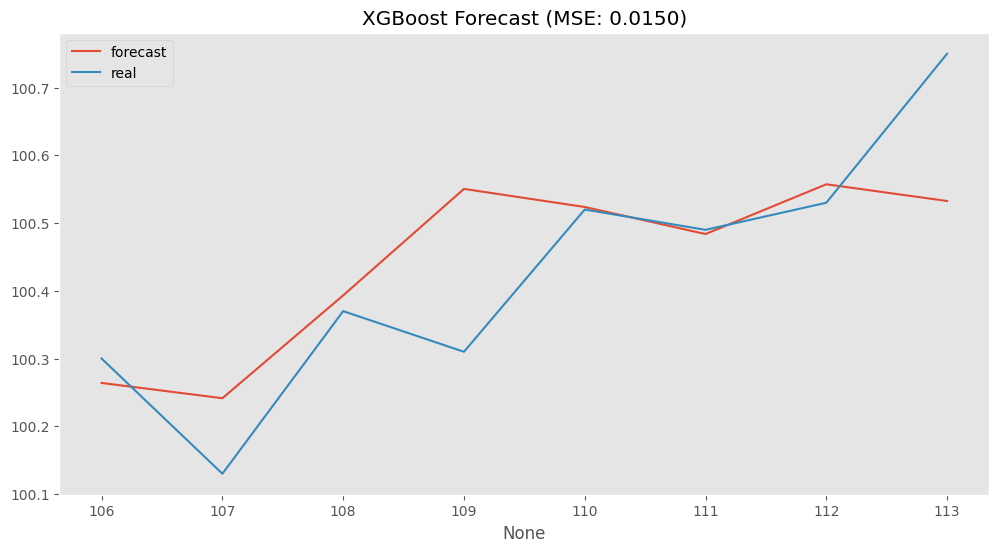

In [19]:
# СДЕЛАЛ УСРЕДНЕНИЕ ШОКОВ
y_train[12] = (y_train[11] + y_train[13]) / 2
y_train[98] = (y_train[97] + y_train[99]) / 2
# Загрузка данных
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

y_train['ds'] = pd.date_range(
    start='2014-01-01', freq='ME', periods=len(y_train))
y_test['ds'] = pd.date_range(end='2023-08-31', freq='ME', periods=len(y_test))
# Создаем фичи для train и test
train_feats = create_features(y_train)
test_feats = create_features(y_test)
# Разделяем на X и y
y_train = train_feats['inflation']
X_train_infl = train_feats.drop(columns=['inflation', 'ds']).join(X_train)

y_test = test_feats['inflation']
X_test_infl = test_feats.drop(columns=['inflation', 'ds']).join(X_test)
# Настройка кросс-валидации для временных рядов
tscv = TimeSeriesSplit(n_splits=3)
# Параметры для подбора
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
# Инициализация и обучение модели
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_infl, y_train)
# Предсказание
xgb_pred = grid_search.predict(X_test_infl)
# Оценка качества
mse = mean_squared_error(y_test, xgb_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Best params: {grid_search.best_params_}")

# Визуализация
plt.figure(figsize=(12, 6))
sb.lineplot(x=y_test.index, y=xgb_pred, label='forecast')
y_test.plot(label='real')
plt.title(f"XGBoost Forecast (MSE: {mse:.4f})")
plt.legend()
plt.grid()
plt.show()